<a href="https://colab.research.google.com/github/Angelvj/Alzheimer-disease-classification/blob/main/code/ad_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os, shutil
import pandas as pd, numpy as np, random
import nibabel as nib
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import re
from google.colab import drive

# Configuration

In [2]:
DEVICE = 'TPU'

if DEVICE == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        STRATEGY = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        print('Could not connect to TPU, setting default strategy')
        tpu = None
        STRATEGY = tf.distribute.get_strategy()
elif DEVICE == 'GPU':
    tpu = None
    STRATEGY = tf.distribute.MirroredStrategy()
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = STRATEGY.num_replicas_in_sync

print(f'Number of accelerators: {REPLICAS}')

Could not connect to TPU, setting default strategy
Number of accelerators: 1


# Functions for loading/creating dataset

In [3]:
def load_image(path):    

    img = nib.load(path)
    img = np.asarray(img.dataobj, dtype=np.float32)
    img = np.expand_dims(img, axis=3) # Add dummy axis for channel
    return img

def read_tfrecord(example):
    tfrec_format = {
        "image": tf.io.VarLenFeature(tf.float32),
        "one_hot_label": tf.io.VarLenFeature(tf.float32)
    }

    example = tf.io.parse_single_example(example, tfrec_format)
    one_hot_label = tf.sparse.to_dense(example['one_hot_label'])
    one_hot_label = tf.reshape(one_hot_label, [NUM_CLASSES])
    image = tf.reshape(tf.sparse.to_dense(example['image']), IMG_SHAPE)
    # TPU needs size to be known, so this doesn't work
    #     image  = tf.reshape(example['image'], example['shape']) 
    return image, one_hot_label


def parse_file(filename, label):

    image = load_image(filename)
    image = np.nan_to_num(image, copy=False)
    label = np.eye(3, dtype=np.float32)[label]

    return image, label

def generator_fn(filenames, labels):

    def images_generator():

        for X, y in zip(filenames, labels):
            X, y = parse_file(X, y)
            yield X, y
    return images_generator

def load_dataset(filenames, labels, use_tfrec):
    
    if use_tfrec:
        # Allow order-altering optimizations
        option_no_order = tf.data.Options()
        option_no_order.experimental_deterministic = False
        
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
        dataset = dataset.with_options(option_no_order)
        dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO)

    else:
        dataset = tf.data.Dataset.from_generator(generator_fn(filenames, labels),
            output_signature=(
                 tf.TensorSpec(shape=IMG_SHAPE, dtype=tf.float32),
                 tf.TensorSpec(shape=(3,), dtype=tf.float32)))

    return dataset

def get_dataset(filenames, labels=None, use_tfrec=True, batch_size = 8, train=False, augment=False, cache=False):
    dataset =  load_dataset(filenames, labels, use_tfrec=use_tfrec)
    if cache:
        dataset = dataset.cache() # Do it only if dataset fits in ram
    if train:
        dataset = dataset.repeat()
        if augment:
            raise NotImplementedError
#             dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        dataset = dataset.shuffle(count_data_items(filenames, use_tfrec))

    dataset = dataset.batch(batch_size * REPLICAS)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames, use_tfrec):
    if use_tfrec:
        n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
            for filename in filenames]
        return np.sum(n)
    else:
        return len(filenames)

# Train schedule

**Note**: not used yet

In [4]:
def get_lr_callback(batch_size=1, verbose=False):
    lr_start = 0.00001
#     lr_max = 0.00004 * REPLICAS
    lr_max = 0.00004 * REPLICAS * batch_size
    lr_min = 0.00001
    lr_rampup_epochs = 3
    lr_sustain_epochs = 0
    lr_exp_decay = 0.7

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = verbose)
    return lr_callback

# Build model

In [5]:
def build_model(input_shape):

    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv3D(filters=16, kernel_size=5, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling3D(pool_size=2)(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=2)(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=256, activation="relu")(x)

    outputs = tf.keras.layers.Dense(units=3, activation="softmax", )(x)

    model = tf.keras.Model(inputs, outputs, name="model_2")
    
    return model

# Visualization

In [6]:
def plot_epochs_history(num_epochs, history):
    # TODO: make a more general function
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(num_epochs), history['accuracy'], '-o', label='Train acc',
            color = '#ff7f0e')
    plt.plot(np.arange(num_epochs), history['val_accuracy'], '-o', label='Val acc',
            color = '#1f77b4')
    x = np.argmax(history['val_accuracy']); y = np.max(history['val_accuracy'])
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
    plt.ylabel('ACC', size=14); plt.xlabel('Epoch', size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(num_epochs),history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(num_epochs),history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'] ); y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.legend(loc=3)
    plt.show()  

# Models evaluation

In [7]:
def evaluate_model_kfold(model_builder, train_filenames, metrics, n_folds, batch_size, epochs, 
                         plot_fold_results = True, plot_avg_results = True, train_labels=None, 
                         stratify=False, shuffle=True, random_state=None, use_tfrec=True):
    
    # np_rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(random_state)))
    folds_history = {metric: [] for metric in metrics}

    if stratify:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)
    else:
        skf = KFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)

    for fold, (idx_train, idx_val) in enumerate(skf.split(train_filenames, train_labels)):
        if tpu != None:
            tf.tpu.experimental.initialize_tpu_system(tpu)

        # np_rs.shuffle(idx_train)
        X_train = train_filenames[idx_train]
        X_val = train_filenames[idx_val]
        y_train = None if train_labels is None else train_labels[idx_train]
        y_val = None if train_labels is None else train_labels[idx_val]

        # Build model
        K.clear_session()
        with STRATEGY.scope():
            model = model_builder(input_shape=IMG_SHAPE)
            model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

        # Train
        print(f'Training for fold {fold + 1} of {n_folds}...')

        history = model.fit(
            get_dataset(X_train, y_train,  use_tfrec, train=True, augment=False, batch_size=batch_size), 
            epochs = EPOCHS, 
            steps_per_epoch = int(np.rint(count_data_items(X_train, use_tfrec)/batch_size/REPLICAS)),
            validation_data = get_dataset(X_val, y_val, use_tfrec, batch_size = batch_size, train=False))
    
        for m in metrics:
            folds_history[m].append(history.history[m])

        if plot_fold_results:
            # TODO: make more general
            plot_epochs_history(epochs, history.history)

    avg_history = dict()
    for m in metrics:
        avg_history[m] = [np.mean([x[i] for x in folds_history[m]]) for i in range(epochs)]

    if plot_avg_results:
        # TODO: make also more general
        plot_epochs_history(epochs, avg_history)

        print('-'*80)
        print('Results per fold')
        for i in range(n_folds):
            print('-'*80)
            print(f"> Fold {i + 1} - Loss: {folds_history['val_loss'][i][-1]} - Accuracy : {folds_history['val_accuracy'][i][-1]}")

        print('-'*80)
        print('Average results over folds:')
        print(f"> Train Accuracy: {avg_history['accuracy'][-1]}")
        print(f"> Train Loss: {avg_history['loss'][-1]}")
        print(f"> CV accuracy: {avg_history['val_accuracy'][-1]}")
        print(f"> CV Loss: {avg_history['val_loss'][-1]}")
        print('-'*80)

    return folds_history

def repeated_kfold(model_builder, train_filenames, metrics, n_folds, batch_size, epochs, reps=5, train_labels=None,
                   stratify=True, shuffle=True, random_state=None, use_tfrec=True):
    
    reps_history = {metric: [] for metric in metrics}
    
    for i in range(reps):
        print(f'Repetition {i + 1}')
        folds_history = evaluate_model_kfold(model_builder, train_filenames, metrics, n_folds,
                                             batch_size, epochs, train_labels=train_labels, stratify=stratify,
                                             shuffle=shuffle, random_state=random_state, use_tfrec=use_tfrec)
        random_state += 1
        avg_folds_history = dict()
        for m in metrics:
            avg_folds_history[m] = [np.mean([x[i] for x in folds_history[m]]) for i in range(epochs)]
        for m in metrics:
            reps_history[m].append(avg_folds_history[m])

    return reps_history

In [8]:
DATASETS = ['tfrec-PET-spatialnorm-elastic',
            'tfrec-PET-spatialnorm-elastic-maxintensitynorm',
            'tfrec-PET-spatialnorm-elastic-standarized',
            'tfrec-PET-spatialnorm-elastic-maxintensitynorm-standarized']
SHAPES = [(79, 95, 68, 1), (79, 95, 68, 1), (79, 95, 68, 1), (79, 95, 68, 1)]
DS_NUM_CLASSES = [3, 3, 3, 3]
REPS = 5
FOLDS = 10
SEED = 268 # Arbitrary seed
CLASSES = ['NOR', 'AD', 'MCI']
METRICS = ['accuracy']
CV_METRICS = ['accuracy', 'val_accuracy', 'loss', 'val_loss']

In [9]:
# # Training model from images directly (only for testing some stuff)
# DATASET = 'ad-preprocessed'
# IMG_SHAPE = SHAPES[0]

# drive.mount('/content/drive')
# DATA_PATH = '/content/drive/My Drive/data/'

# DS = 'ad-preprocessed'
# DS_PATH =  DATA_PATH + DS

# # Path to images
# pet_paths = np.empty((0,), dtype=str)
# pet_labels = np.empty((0,), dtype=np.int64)

# for label, c in enumerate(CLASSES):
#     pattern = os.path.join(DS_PATH, c, 'PET') + '/*.nii'
#     pet_paths = np.concatenate((pet_paths, np.array(tf.io.gfile.glob(pattern))))
#     pet_labels = np.concatenate((pet_labels, np.full(len(pet_paths) - len(pet_labels), label, dtype=np.int64)))

# X_train, X_test, y_train, y_test = train_test_split(pet_paths, pet_labels, 
#                                                     stratify = pet_labels,
#                                                     test_size = 0.2,
#                                                     shuffle=True,
#                                                     random_state=SEED)

# # LR = 0.00001
# # BATCH_SIZE = 4

# LR = 0.00008
# BATCH_SIZE = 64

# OPT = tf.keras.optimizers.Adam(learning_rate=LR)
# LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0)
# METRICS = ['accuracy']

# FOLDS = 10
# DISPLAY_PLOT = True
# DISPLAY_AVG_PLOT = True
# EPOCHS = 54

# # evaluate_model_kfold(build_model, X_train, FOLDS, BATCH_SIZE, EPOCHS, train_labels=y_train,
# #                      stratify=True, random_state=SEED, use_tfrec=False)

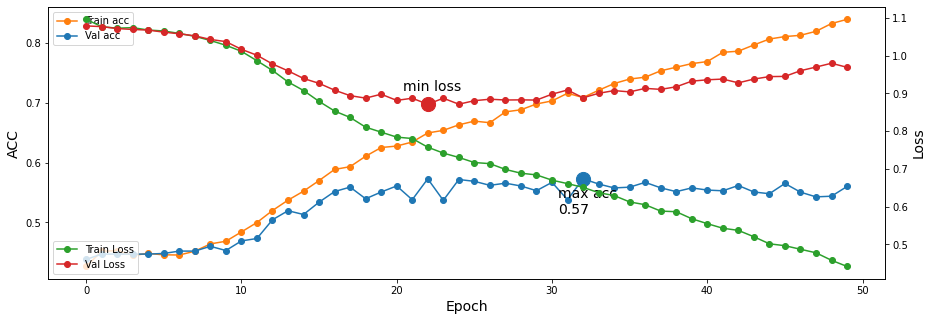

--------------------------------------------------------------------------------
Results per repetition
--------------------------------------------------------------------------------
> Repetition 1 - Loss: 0.9523716449737549 - Accuracy : 0.5634210556745529
--------------------------------------------------------------------------------
> Repetition 2 - Loss: 0.9910757064819335 - Accuracy : 0.5431578904390335
--------------------------------------------------------------------------------
> Repetition 3 - Loss: 0.9566056787967682 - Accuracy : 0.573421061038971
--------------------------------------------------------------------------------
> Repetition 4 - Loss: 0.9855525255203247 - Accuracy : 0.5381578862667084
--------------------------------------------------------------------------------
> Repetition 5 - Loss: 0.9595764219760895 - Accuracy : 0.5823684185743332
--------------------------------------------------------------------------------
Average results over repetitions (on last

In [12]:
# Training model form tfrecords
DATASET = DATASETS[0]
IMG_SHAPE = SHAPES[0]
NUM_CLASSES = DS_NUM_CLASSES[0]

# Access to data on google Drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/data/'
DS_PATH = DATA_PATH + DATASET

# Read data filenames
metadata_train = pd.read_csv(DS_PATH + '/train/train_summary.csv', encoding='utf-8')
X_train = DS_PATH + '/train/' + metadata_train.iloc[:, 0].to_numpy()
y_train = np.argmax(metadata_train.iloc[:,-len(CLASSES):].to_numpy(), axis=1)
X_test = np.array(tf.io.gfile.glob(DS_PATH + '/test/*.tfrec'))

# Select hyperparameters (some of them)
LR = 0.00001 # 0.00008
BATCH_SIZE = 4 # 64
OPT = tf.keras.optimizers.Adam(learning_rate=LR)
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.00)
EPOCHS = 50

DISPLAY_PLOT = True
DISPLAY_AVG_PLOT = True


# Evaluate model with repeated k-fold (because of the high variance)
# evaluate_model_kfold(build_model, X_train, CV_METRICS, FOLDS, BATCH_SIZE, EPOCHS, train_labels=y_train,
#                      stratify=True, random_state=SEED, use_tfrec=True)
reps_results = repeated_kfold(build_model, X_train, CV_METRICS, FOLDS, BATCH_SIZE, EPOCHS, reps=REPS, train_labels=y_train,
               random_state=SEED)

# Average results in the different k-fold executions
reps_avg = dict()
for m in CV_METRICS:
    reps_avg[m] = [np.mean([x[i] for x in reps_results[m]]) for i in range(EPOCHS)]

# Plot results over epochs
plot_epochs_history(EPOCHS, reps_avg)

print('-'*80)
print('Results per repetition')
for i in range(REPS):
    print('-'*80)
    print(f"> Repetition {i + 1} - Loss: {reps_results['val_loss'][i][-1]} - Accuracy : {reps_results['val_accuracy'][i][-1]}")

print('-'*80)
print('Average results over repetitions (on last epoch):')
print(f"> Train Accuracy: {reps_avg['accuracy'][-1]}")
print(f"> Train Loss: {reps_avg['loss'][-1]}")
print(f"> CV accuracy: {reps_avg['val_accuracy'][-1]}")
print(f"> CV Loss: {reps_avg['val_loss'][-1]}")
print('-'*80)

# # Test model
# model = build_model(IMG_SHAPE)
# model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)
# history = model.fit(
#     get_dataset(X_train, train=True, batch_size=BATCH_SIZE), 
#     epochs = EPOCHS, 
#     steps_per_epoch = int(np.rint(count_data_items(X_train, use_tfrec=True)/BATCH_SIZE/REPLICAS))
#     )

# results = model.evaluate(
#     get_dataset(X_test)
# )